Data init

In [1]:
import math

def read_obj(file, cnt):
  features = []
  targets = []
  for i in range(cnt):
    line = list(map(float, file.readline().split()))
    features.append(line[:-1])
    targets.append(line[-1])
  return features, targets

def scalar_product(m, a, b):
  return sum([a[j] * b[j] for j in range(m)])

def nrmse(n, m, features, targets, w, target_diff):
  diffs = [(scalar_product(m, w, features[i]) - targets[i]) ** 2 for i in range(n)]
  return math.sqrt(sum(diffs) / n) / target_diff

file_num = 1
with open("data1/0{}.txt".format(file_num)) as file:
  feature_size = int(file.readline())
  size = int(file.readline())
  features, targets = read_obj(file, size)

  test_size = int(file.readline())
  test_features, test_targets = read_obj(file, test_size)

train_target_min = min(targets)
train_target_max = max(targets)
train_targets_diff = train_target_max - train_target_min
print("Train targets min: {}\nTrain targets max: {}\nTrain targets diff: {}".format(train_target_min, train_target_max, train_targets_diff))

test_target_min = min(test_targets)
test_target_max = max(test_targets)
test_targets_diff = test_target_max - test_target_min
print("\nTest targets min: {}\nTest targets max: {}\nTest targets diff: {}".format(test_target_min, test_target_max, test_targets_diff))

FileNotFoundError: [Errno 2] No such file or directory: 'data1/01.txt'

Pseudoinverse matrix

In [9]:
import numpy

def pseudo_inverse_matrix(features, targets):
  return numpy.matmul(numpy.linalg.pinv(features), targets)

matrix_result = pseudo_inverse_matrix(features, targets)
matrix_nrmse_train = nrmse(test_size, feature_size, features, targets, matrix_result, train_targets_diff)
matrix_nrmse_test = nrmse(test_size, feature_size, test_features, test_targets, matrix_result, test_targets_diff)

Fast gradient descent

In [10]:
from subprocess import Popen, PIPE, STDOUT

def fgd(max_iter, reg_coef, file_num=4): 
  p = Popen(["./LinearRegression"], stdout=PIPE, stdin=PIPE, stderr=STDOUT) 
  p_stdout = p.communicate(input=bytes(str(file_num) + " " + str(max_iter) + " " + str(reg_coef), encoding='utf-8'))[0] 
  output = p_stdout.decode('utf-8').strip().split("\n") 
  train_nrmse = []
  test_nrmse = []
  for line in output:
    l = list(map(float, line.split()))
    train_nrmse.append(l[0])
    test_nrmse.append(l[1])
  return train_nrmse, test_nrmse

In [11]:
best = 1
best_nrmse = 1e9
for i in range(1, 101):
  cur_nrmse, _ = fgd(1000, 1 / i)
  cur_nrmse = cur_nrmse[-1]
  if cur_nrmse < best_nrmse:
    best_nrmse = cur_nrmse
    best = i
  print("\r{}/{}".format(i, 100), end='')

print("\nBest reg coef: {} (1 / {}) with nrmse = {}".format(1 / best, best, best_nrmse))

100/100
Best reg coef: 0.045454545454545456 (1 / 22) with nrmse = 0.136831


In [12]:
fgd_iter=30000
fgd_train_errors, fgd_test_errors = fgd(fgd_iter, 1 / best)

Genetic algorithm

In [50]:
import pygad

def fitness_func(solution, solution_idx):
    return -nrmse(size, feature_size, features, targets, solution, train_targets_diff)

best_sol_per_pop = 2
best_num_parents_mating = 1
best_keep_parents = -1
best_parent_selection_type = "sss"
best_crossover_type = "single_point"
best_mutation_type = "random"
best_mutation_percent_genes = 10

best_gen_nrmse = -1e9

all = 0

for sol_per_pop in range(3, 8, 2):
  for num_parents_mating in [1, sol_per_pop]:#range(1, sol_per_pop + 1, 2):
    for keep_parents in [-1, 1]:#range(-1, num_parents_mating + 1, 2):
      for parent_selection_type in ["sss", "random"]: #["sss", "rws", "sus", "random", "rank"]:
        for crossover_type in [None, "single_point"]: #[None, "single_point", "two_points", "uniform"]:
          for mutation_type in ["scramble"]: #[None, "random", "swap", "scramble", "inversion"]:
            for mutation_percent_genes in range(10, 70, 20): #range(10, 90, 30):
              all = all + 1

cur = 0
for sol_per_pop in range(3, 8, 2):
  for num_parents_mating in [1, sol_per_pop]:#range(1, sol_per_pop + 1, 2):
    for keep_parents in [-1, 1]:#range(-1, num_parents_mating + 1, 2):
      for parent_selection_type in ["sss", "random"]: #["sss", "rws", "sus", "random", "rank"]:
        for crossover_type in [None, "single_point"]: #[None, "single_point", "two_points", "uniform"]:
          for mutation_type in ["scramble"]: #[None, "random", "swap", "scramble", "inversion"]:
            for mutation_percent_genes in range(10, 70, 20): #range(10, 90, 30):
              try:
                if crossover_type == None and mutation_type == None:
                  continue
                ga_instance = pygad.GA(num_generations=15,
                                       num_genes=feature_size,
                                       sol_per_pop=sol_per_pop,
                                       num_parents_mating=num_parents_mating,
                                       parent_selection_type=parent_selection_type,
                                       crossover_type=crossover_type,
                                       mutation_type=mutation_type,
                                       mutation_percent_genes=mutation_percent_genes,
                                       keep_parents=keep_parents,
                                       fitness_func=fitness_func,
                                       init_range_low=-100,
                                       init_range_high=100)

                ga_instance.run()
                cur_nrmse = ga_instance.best_solutions_fitness[-1]
                if cur_nrmse > best_gen_nrmse:
                  best_gen_nrmse = cur_nrmse
                  best_sol_per_pop = sol_per_pop
                  best_num_parents_mating = num_parents_mating
                  best_keep_parents = keep_parents
                  best_parent_selection_type = parent_selection_type
                  best_crossover_type = crossover_type
                  best_mutation_type = mutation_type
                  best_mutation_percent_genes = mutation_percent_genes
                  print("\r{}/{}".format(cur, all), end='')
                  print("; Local best: {}, {}, {}, {}, {}, {}, {}".format(best_sol_per_pop,
                                                                          best_num_parents_mating,
                                                                          best_keep_parents,
                                                                          best_parent_selection_type,
                                                                          best_crossover_type,
                                                                          best_mutation_type,
                                                                          best_mutation_percent_genes), end = ' ')  
              except Exception:
                pass
              finally:
                cur = cur + 1
                print("\r{}/{}".format(cur, all), end='')

print("\nBest sol_per_pop: {}".format(best_sol_per_pop))
print("Best num_parents_mating: {}".format(best_num_parents_mating))
print("Best keep_parents: {}".format(best_keep_parents))
print("Best parent_selection_type: {}".format(best_parent_selection_type))
print("Best crossover_type: {}".format(best_crossover_type))
print("Best mutation_type: {}".format(best_mutation_type))
print("Best mutation_percent_genes: {}".format(best_mutation_percent_genes))

144/144
Best sol_per_pop: 7
Best num_parents_mating: 1
Best keep_parents: -1
Best parent_selection_type: sss
Best crossover_type: None
Best mutation_type: scramble
Best mutation_percent_genes: 10


In [75]:
num_generations = 100
gen_w = []
ga_instance = pygad.GA(num_generations=1,
                       num_genes=feature_size,
                       sol_per_pop=best_sol_per_pop,
                       num_parents_mating=best_num_parents_mating,
                       parent_selection_type=best_parent_selection_type,
                       crossover_type=best_crossover_type,
                       mutation_type=best_mutation_type,
                       mutation_percent_genes=best_mutation_percent_genes,
                       keep_parents=best_keep_parents,
                       fitness_func=fitness_func,
                       init_range_low=-100,
                       init_range_high=100)
for i in range(num_generations):    
  ga_instance.run()
  gen_w.append(ga_instance.best_solution()[0])
  print("\r{}/{}".format(i + 1, num_generations), end='')

100/100

In [76]:
gen_train_err = list(map(lambda w: nrmse(size, feature_size, features, targets, w, train_targets_diff), gen_w))
gen_test_err = list(map(lambda w: nrmse(test_size, feature_size, test_features, test_targets, w, test_targets_diff), gen_w))

Plots

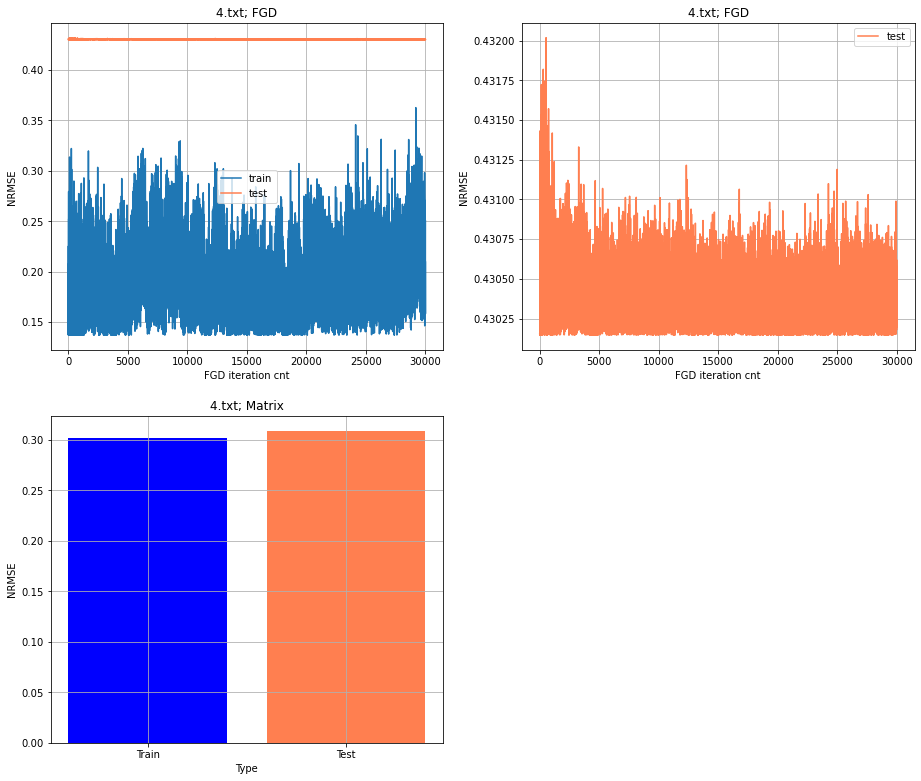

In [13]:
import matplotlib.pyplot as plt

plt.figure()

plt.subplot(2, 2, 1)
plt.title('{}.txt; FGD'.format(4))
plt.ylabel('NRMSE')
plt.xlabel('FGD iteration cnt')
plt.plot(range(1, fgd_iter + 1), fgd_train_errors, label='train')
plt.plot(range(1, fgd_iter + 1), fgd_test_errors, label='test', color="coral")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('{}.txt; FGD'.format(4))
plt.ylabel('NRMSE')
plt.xlabel('FGD iteration cnt')
plt.plot(range(1, fgd_iter + 1), fgd_test_errors, label='test', color="coral")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('{}.txt; Matrix'.format(4))
plt.ylabel('NRMSE')
plt.xlabel('Type')
plt.bar(["Train", "Test"], [matrix_nrmse_train, matrix_nrmse_test], color=["blue", "coral"])
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('{}.txt; Gen alg'.format(4))
plt.ylabel('NRMSE')
plt.xlabel('Num generations')
plt.plot(range(1, num_generations + 1), gen_train_err, label='train')
plt.plot(range(1, num_generations + 1), gen_test_err, label='test', color="coral")
plt.legend()
plt.grid(True)


plt.subplots_adjust(top=2.5, bottom=0, left=0, right=2)
plt.show()